# Проект: Обучение с учителем: качество модели

## Описание проекта:

Необходимо разработать решение, которое позволит персонализировать предложения постоянным клиентам, чтобы увеличить их покупательскую активность.

## Как решать задачу?
1. Нужно промаркировать уровень финансовой активности постоянных покупателей. В компании принято выделять два уровня активности: «снизилась», если клиент стал покупать меньше товаров, и «прежний уровень».


2. Нужно собрать данные по клиентам по следующим группам:
    - Признаки, которые описывают коммуникацию сотрудников компании с клиентом.
    - Признаки, которые описывают продуктовое поведение покупателя. Например, какие товары покупает и как часто.
    - Признаки, которые описывают покупательское поведение клиента. Например, сколько тратил в магазине.
    - Признаки, которые описывают поведение покупателя на сайте. Например, как много страниц просматривает и сколько времени проводит на сайте.
    
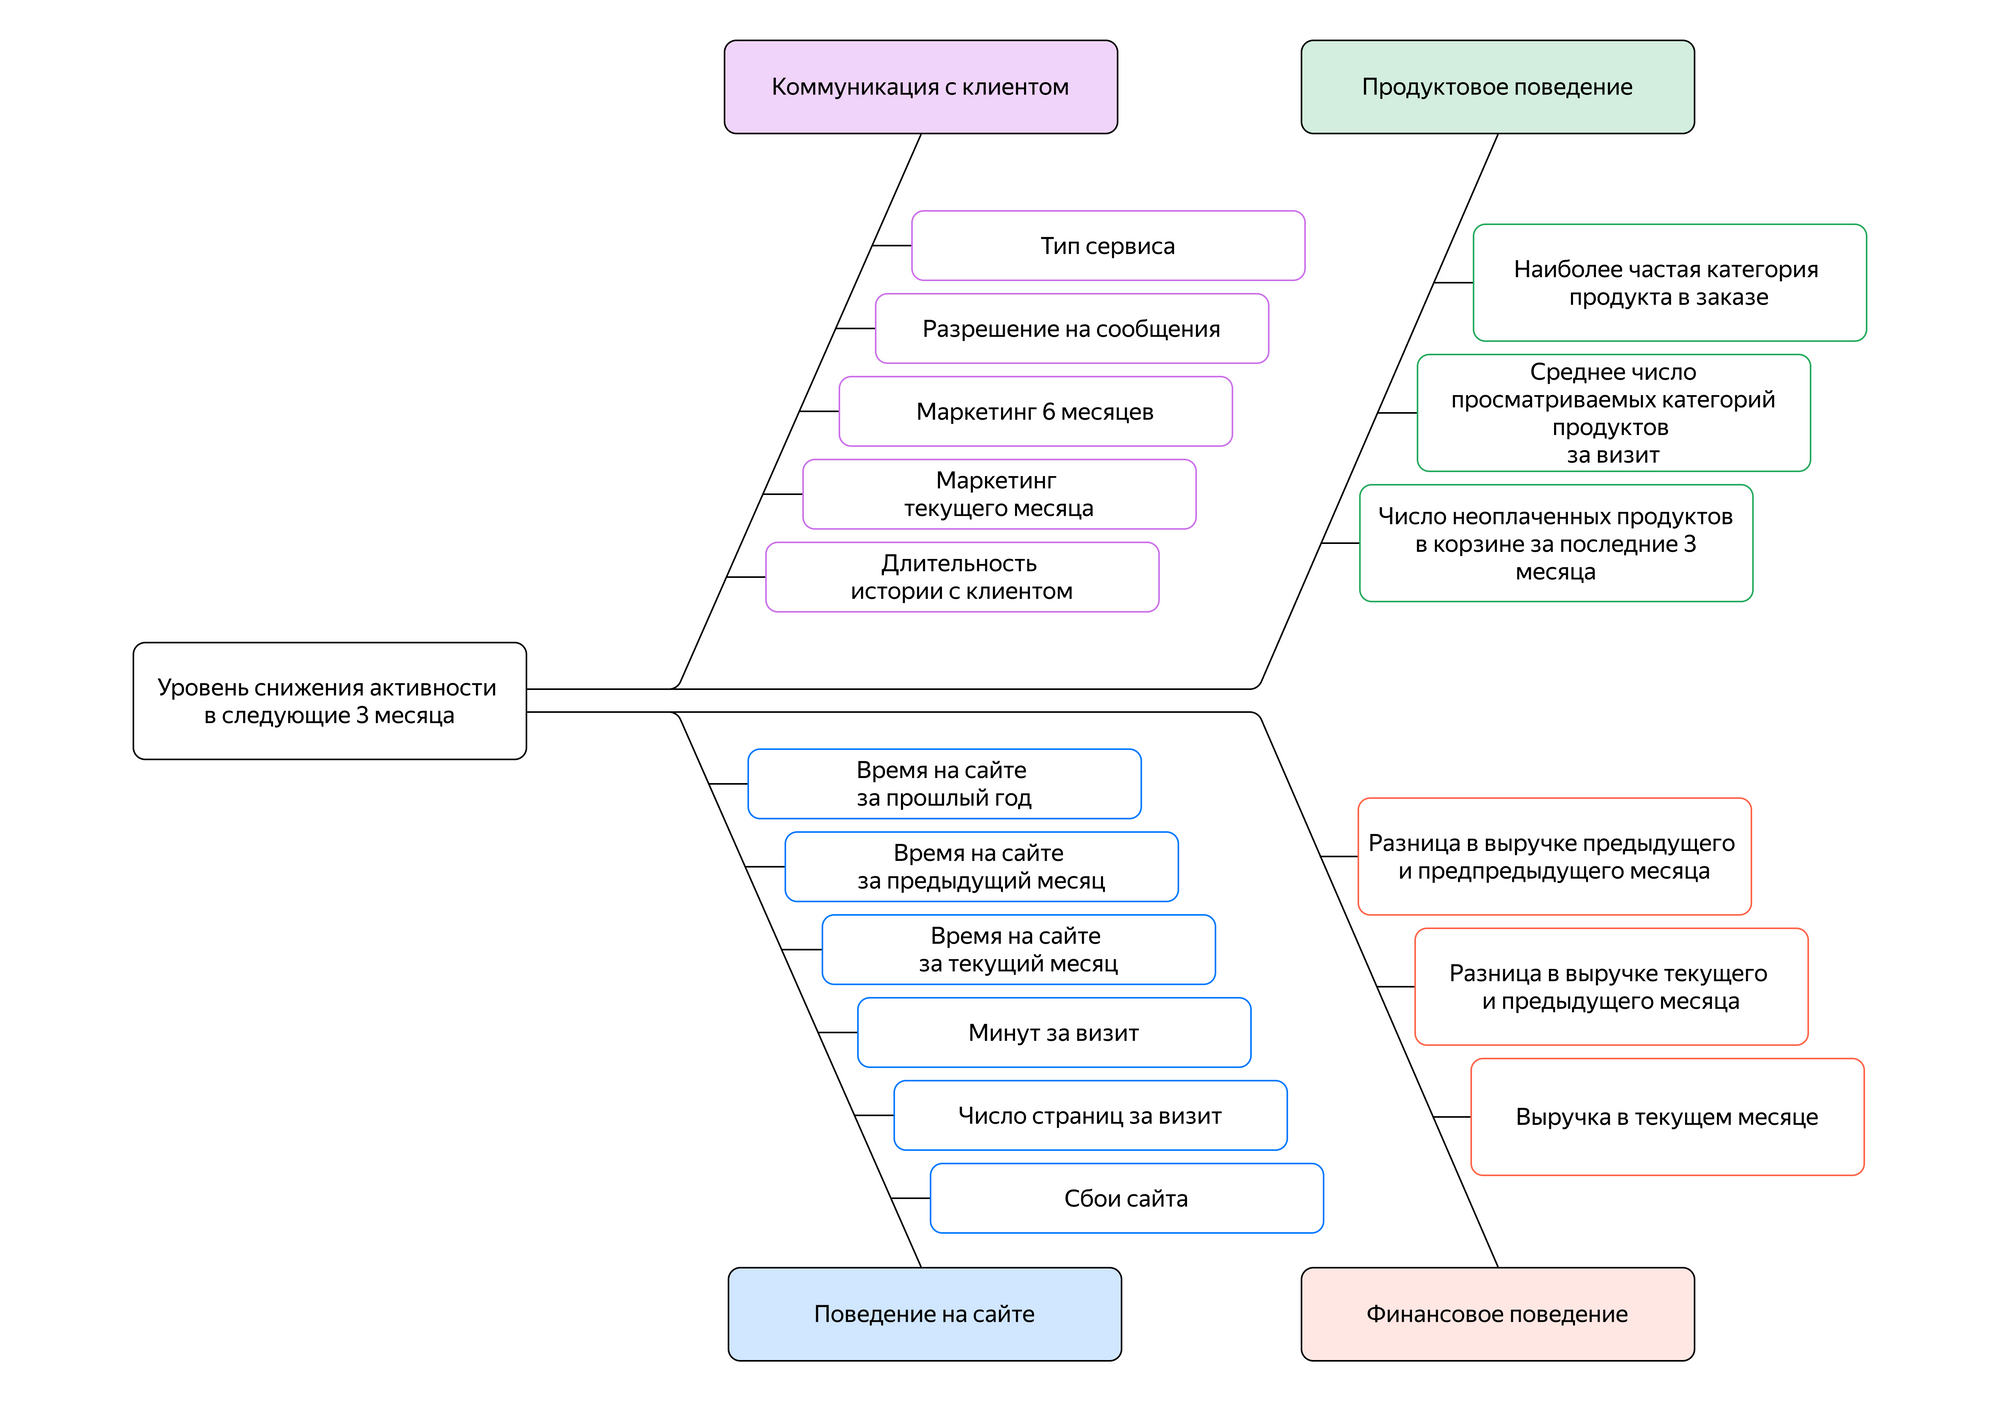

## Задачи:


1. Нужно построить модель, которая предскажет вероятность снижения покупательской активности клиента в следующие три месяца.


2. В исследование нужно включить дополнительные данные финансового департамента о прибыльности клиента: какой доход каждый покупатель приносил компании за последние три месяца.


3. Используя данные модели и данные о прибыльности клиентов, нужно выделить сегменты покупателей и разработать для них персонализированные предложения.

## Шаг 1. Загрузка данных

<span style="color: blue; font-weight: bold">Комментарий ревьюера 2: </span> ✔️\
<span style="color: green"> Отлично!  👍</span>

In [1]:
!pip install --upgrade scikit-learn

     |████████████████████████████████| 13.5 MB 2.5 MB/s eta 0:00:01
     |████████████████████████████████| 307 kB 71.8 MB/s eta 0:00:01
  Attempting uninstall: joblib
    Found existing installation: joblib 1.1.0
    Uninstalling joblib-1.1.0:
      Successfully uninstalled joblib-1.1.0
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.24.1
    Uninstalling scikit-learn-0.24.1:
      Successfully uninstalled scikit-learn-0.24.1


In [2]:
!pip install shap

     |████████████████████████████████| 997 kB 2.7 MB/s eta 0:00:01


In [3]:
!pip install matplotlib==3.5.0

     |████████████████████████████████| 11.2 MB 1.3 MB/s eta 0:00:01
     |████████████████████████████████| 62 kB 472 kB/s  eta 0:00:01
     |████████████████████████████████| 4.8 MB 54.5 MB/s eta 0:00:01
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.3.4
    Uninstalling matplotlib-3.3.4:
      Successfully uninstalled matplotlib-3.3.4


In [4]:
!pip install phik

     |████████████████████████████████| 677 kB 2.3 MB/s eta 0:00:01


In [5]:
#импорт всех необходимых библиотек
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
import seaborn as sns
# загружаем класс pipeline
from sklearn.pipeline import Pipeline

# загружаем классы для подготовки данных
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer

# загружаем функцию для работы с метриками
from sklearn.metrics import roc_auc_score

# импортируем класс RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV

# загружаем нужные модели
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

from sklearn.tree import plot_tree

from phik import phik_matrix

from phik.report import plot_correlation_matrix

plt.rcParams["figure.figsize"] = (10,4)

In [6]:
#считываем все данные и заносим в переменнные
df_1 = pd.read_csv('/datasets/market_file.csv')
df_2 = pd.read_csv('/datasets/market_money.csv')
df_3 = pd.read_csv('/datasets/market_time.csv')
df_4 = pd.read_csv('/datasets/money.csv', sep=';')

Выведем начало всех таблиц (первые пять строк), а также получим информацию по каждой из них для лучшего ознакомления с данными

In [7]:
df_1.head()

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


In [8]:
df_2.head()

,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


In [9]:
df_3.head()

,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


In [10]:
df_4.head()

,id,Прибыль
0,215348,"0,98"
1,215349,"4,16"
2,215350,"3,13"
3,215351,"4,87"
4,215352,"4,21"


In [11]:
df_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

In [12]:
df_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


In [13]:
df_3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


In [14]:
df_4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       1300 non-null   int64 
 1   Прибыль  1300 non-null   object
dtypes: int64(1), object(1)
memory usage: 20.4+ KB


**Вывод по разделу 1:** 
Успешно загрузили каждый датафрейм и присвоили каждому по переменной df_1, df_2, df_3, df_4. Датафрейм df_4 разделили с помощью разделителя ";". Вывели каждую таблицу для лучшего ознакомления, а также получили базовую информацию по каждой таблице. У таблицы 1: 1300 строк, 13 столбцов. У таблицы 2: 3900 строк, 3 столбца. У таблицы 3: 2600 строк, 3 столбца. У таблицы 4: 1300 строк, 2 столбца. Все имеющийся таблицы полностью соответсвуют своим описаниям. 

## Шаг 2. Предобработка данных

In [15]:
#приведем все названия столбцов в нижний регистр
df_1.columns = df_1.columns.str.lower()
df_2.columns = df_2.columns.str.lower()
df_3.columns = df_3.columns.str.lower()
df_4.columns = df_4.columns.str.lower()

In [16]:
#проверим, что везде названия столбцов приведены к нижнему регистру
dataframes = [df_1, df_2, df_3, df_4]
for i in dataframes:
    print(i.columns)

Index(['id', 'покупательская активность', 'тип сервиса', 'разрешить сообщать',
       'маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность',
       'акционные_покупки', 'популярная_категория',
       'средний_просмотр_категорий_за_визит',
       'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса',
       'страниц_за_визит'],
      dtype='object')
Index(['id', 'период', 'выручка'], dtype='object')
Index(['id', 'период', 'минут'], dtype='object')
Index(['id', 'прибыль'], dtype='object')


In [17]:
#проверим каждый датафрейм на наличие пропусков
for i in dataframes:
    print(i.isna().sum(), '\n')

id                                     0
покупательская активность              0
тип сервиса                            0
разрешить сообщать                     0
маркет_актив_6_мес                     0
маркет_актив_тек_мес                   0
длительность                           0
акционные_покупки                      0
популярная_категория                   0
средний_просмотр_категорий_за_визит    0
неоплаченные_продукты_штук_квартал     0
ошибка_сервиса                         0
страниц_за_визит                       0
dtype: int64 

id         0
период     0
выручка    0
dtype: int64 

id        0
период    0
минут     0
dtype: int64 

id         0
прибыль    0
dtype: int64 



In [18]:
#проверим каждый датафрейм на наличие явных дубликатов
for i in dataframes:
    print(i.duplicated().sum(), '\n')

0 

0 

0 

0 



In [19]:
#проверка df_1 на неявные дубликаты в столбцах
columns_df_1 = ['покупательская активность', 'тип сервиса', 'разрешить сообщать', 'популярная_категория']
for i in columns_df_1:
    print(df_1[i].unique())

['Снизилась' 'Прежний уровень']
['премиум' 'стандартт' 'стандарт']
['да' 'нет']
['Товары для детей' 'Домашний текстиль' 'Косметика и аксесуары'
 'Техника для красоты и здоровья' 'Кухонная посуда'
 'Мелкая бытовая техника и электроника']


In [20]:
#заменим "стандартт" на "стандарт"
df_1['тип сервиса'] = df_1['тип сервиса'].replace('стандартт', 'стандарт')

<span style="color: blue; font-weight: bold">Комментарий ревьюера : </span> ✔️\
<span style="color: green"> 👍</span>

In [21]:
#повторная проверка df_1 на неявные дубликаты в столбцах
columns_df_1 = ['покупательская активность', 'тип сервиса', 'разрешить сообщать', 'популярная_категория']
for i in columns_df_1:
    print(df_1[i].unique())

['Снизилась' 'Прежний уровень']
['премиум' 'стандарт']
['да' 'нет']
['Товары для детей' 'Домашний текстиль' 'Косметика и аксесуары'
 'Техника для красоты и здоровья' 'Кухонная посуда'
 'Мелкая бытовая техника и электроника']


In [22]:
df_2['период'].unique()

array(['препредыдущий_месяц', 'текущий_месяц', 'предыдущий_месяц'],
      dtype=object)

In [23]:
df_3['период'].unique()

array(['текущий_месяц', 'предыдцщий_месяц'], dtype=object)

In [24]:
#исправление орфографической ошибки в данных
df_3['период'] = df_3['период'].replace('предыдцщий_месяц', 'предыдущий_месяц')

<span style="color: blue; font-weight: bold">Комментарий ревьюера : </span> ✔️\
<span style="color: green"> 👍</span>

In [25]:
#исправление названий столбцов в df_1
df_1 = df_1.rename(columns={'покупательская активность': 'покупательская_активность', 'тип сервиса': 'тип_сервиса', 'разрешить сообщать': 'разрешить_сообщать'})

In [26]:
#проверка изменения названия столбцов
df_1.columns

Index(['id', 'покупательская_активность', 'тип_сервиса', 'разрешить_сообщать',
       'маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность',
       'акционные_покупки', 'популярная_категория',
       'средний_просмотр_категорий_за_визит',
       'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса',
       'страниц_за_визит'],
      dtype='object')

In [27]:
#переведем в таблице df_4 столбец прибыль в тип numeric
df_4['прибыль'] = pd.to_numeric(df_4['прибыль'].str.replace(',', '.'), errors='raise')

**Вывод по разделу 2:**
Провели необходимую предобработку данных. Проверили датасеты на наличие пропусков, явных и неявных дубликатов. Изменили названия столбцов и привели к нижнему регистру. Также в датафрейме df_4 заменили колонку прибыль со строкового формата в числовой. 

## Шаг 3. Исследовательский анализ данных

**Проведите исследовательский анализ данных из каждой таблицы.**

**Для датафрейма df_1:**

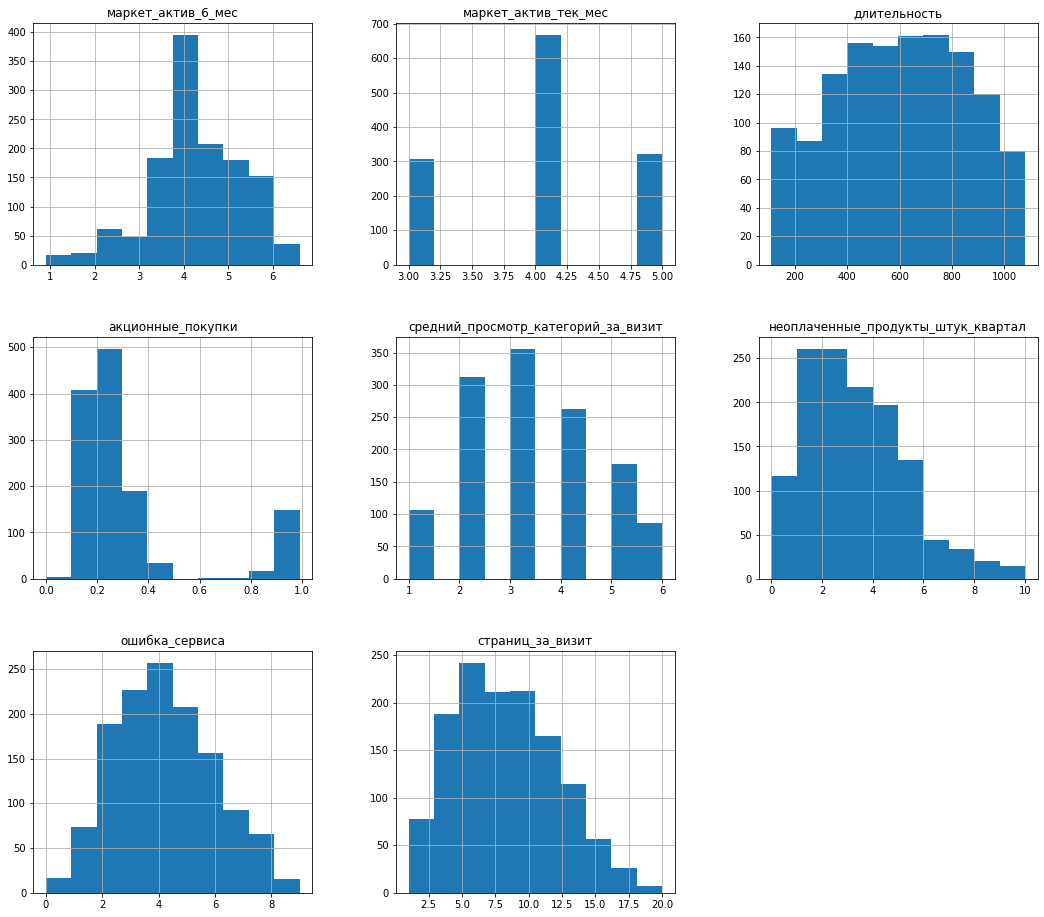

In [28]:
df_1.drop('id', axis=1).hist(figsize=(18, 16))
plt.show()

<span style="color: blue; font-weight: bold">Комментарий ревьюера 2: </span> ✔️\
<span style="color: green"> 👍</span>

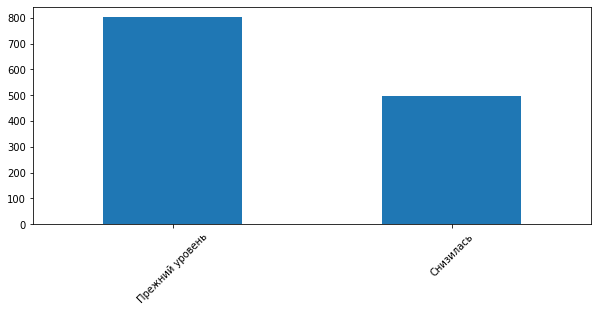

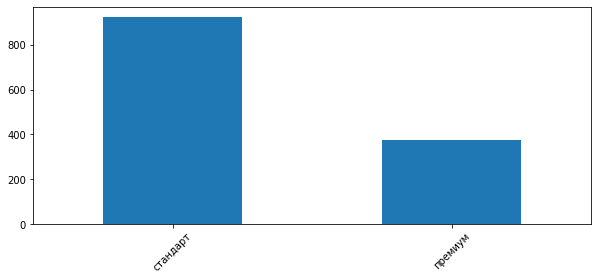

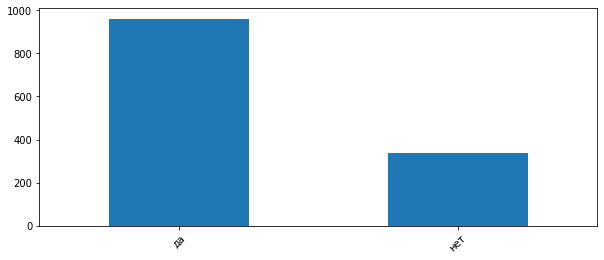

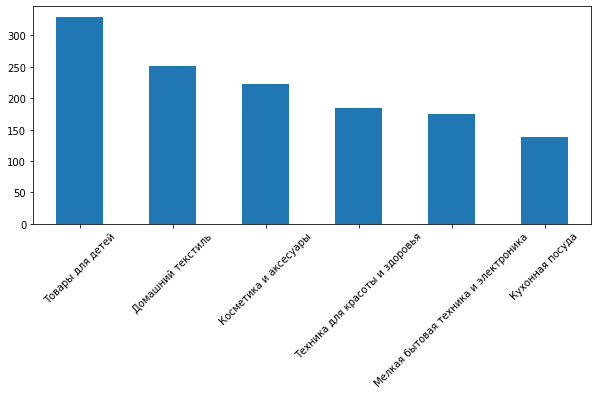

In [29]:
#создадим список категориальных столбцов для df_1 и с помощью цикла выведем гистограммы для каждого категориального столбца
cat_columns = ['покупательская_активность', 'тип_сервиса', 'разрешить_сообщать', 'популярная_категория']
for i in cat_columns:
    df_1[i].value_counts().plot(kind='bar')
    plt.xticks(rotation=45)
    plt.show()

<span style="color: blue; font-weight: bold">Комментарий ревьюера 2: </span> ✔️\
<span style="color: green"> Отлично!  👍</span>

In [30]:
#выведем статистику по датафрейму 1 (df_1)
df_1.describe()

,id,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит
count,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.00000,1300.000000,1300.000000,1300.000000
mean,215997.500000,4.253769,4.011538,601.898462,0.319808,3.27000,2.840000,4.185385,8.176923
std,375.421985,1.014814,0.696868,249.856289,0.249843,1.35535,1.971451,1.955298,3.978126
min,215348.000000,0.900000,3.000000,110.000000,0.000000,1.00000,0.000000,0.000000,1.000000
25%,215672.750000,3.700000,4.000000,405.500000,0.170000,2.00000,1.000000,3.000000,5.000000
50%,215997.500000,4.200000,4.000000,606.000000,0.240000,3.00000,3.000000,4.000000,8.000000
75%,216322.250000,4.900000,4.000000,806.000000,0.300000,4.00000,4.000000,6.000000,11.000000
max,216647.000000,6.600000,5.000000,1079.000000,0.990000,6.00000,10.000000,9.000000,20.000000


Вывод по датафрейму 1 (df_1): аномалий в датафрейме не обнаружено.

**Для датафрейма df_2:**

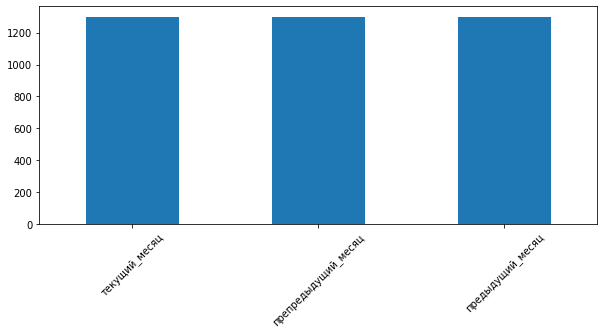

In [31]:
df_2['период'].value_counts().plot(kind='bar')
plt.xticks(rotation=45)
plt.show()

In [32]:
df_2.describe()

,id,выручка
count,3900.000000,3900.000000
mean,215997.500000,5025.696051
std,375.325686,1777.704104
min,215348.000000,0.000000
25%,215672.750000,4590.150000
50%,215997.500000,4957.500000
75%,216322.250000,5363.000000
max,216647.000000,106862.200000


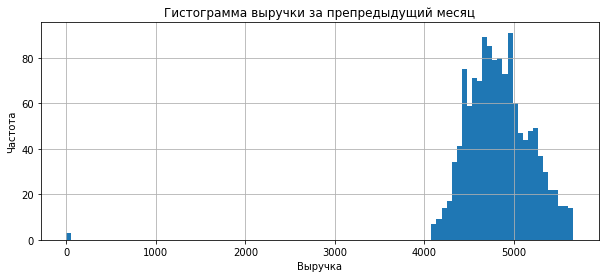

In [33]:
df_2[df_2['период']=='препредыдущий_месяц']['выручка'].hist(bins=100)
plt.xlabel('Выручка')
plt.ylabel('Частота')
plt.title('Гистограмма выручки за препредыдущий месяц')
plt.show()

<span style="color: blue; font-weight: bold">Комментарий ревьюера 4: </span> ✔️\
<span style="color: green"> 👍</span>

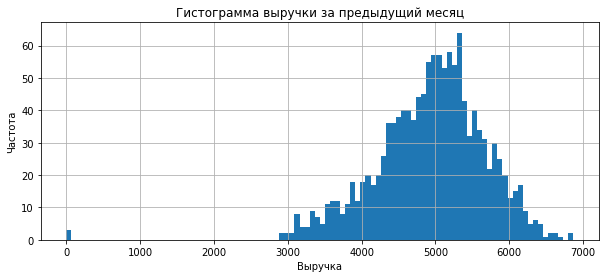

In [34]:
df_2[df_2['период']=='предыдущий_месяц']['выручка'].hist(bins=100)
plt.xlabel('Выручка')
plt.ylabel('Частота')
plt.title('Гистограмма выручки за предыдущий месяц')
plt.show()

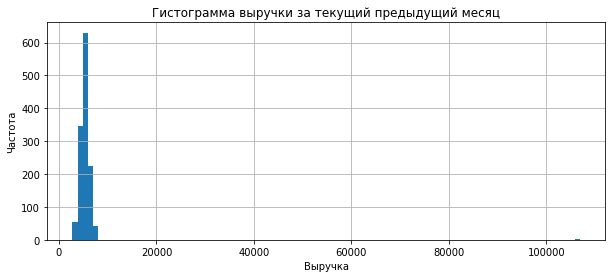

In [35]:
df_2[df_2['период']=='текущий_месяц']['выручка'].hist(bins=100)
plt.xlabel('Выручка')
plt.ylabel('Частота')
plt.title('Гистограмма выручки за текущий предыдущий месяц')
plt.show()

In [36]:
#удалим выброс
df_2 = df_2.query('выручка < 20000')

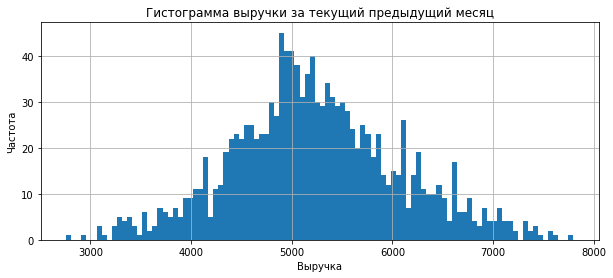

In [37]:
#повторная проверка
df_2[df_2['период']=='текущий_месяц']['выручка'].hist(bins=100)
plt.xlabel('Выручка')
plt.ylabel('Частота')
plt.title('Гистограмма выручки за текущий предыдущий месяц')
plt.show()

Вывод по датафрейму df_2: обнаружили аномалию. Удалили выброс. 

**Для датафрейма df_3:**

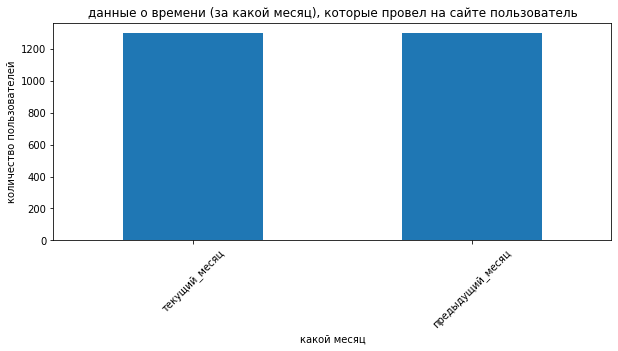

In [38]:
df_3['период'].value_counts().plot(kind='bar')
plt.xlabel('какой месяц')
plt.xticks(rotation=45)
plt.ylabel('количество пользователей')
plt.title('данные о времени (за какой месяц), которые провел на сайте пользователь')
plt.show()

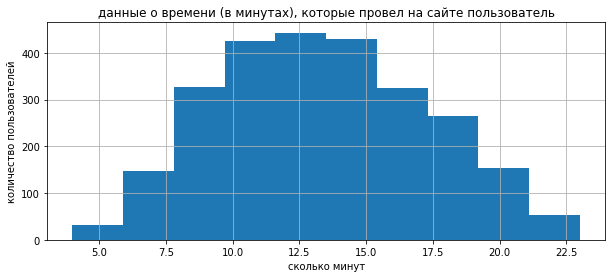

In [39]:
df_3['минут'].hist(grid=True)
plt.xlabel('сколько минут')
plt.ylabel('количество пользователей')
plt.title('данные о времени (в минутах), которые провел на сайте пользователь')
plt.show()

In [40]:
df_3.describe()

,id,минут
count,2600.000000,2600.000000
mean,215997.500000,13.336154
std,375.349754,4.080198
min,215348.000000,4.000000
25%,215672.750000,10.000000
50%,215997.500000,13.000000
75%,216322.250000,16.000000
max,216647.000000,23.000000


Вывод по датафрейму df_3: аномалий в данных не обнаружено.

**Для датафрейма df_4:**

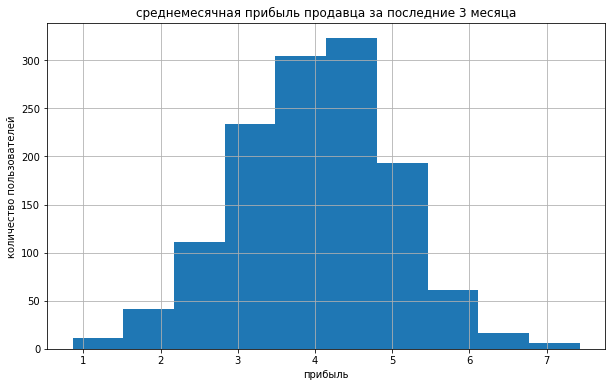

In [41]:
df_4['прибыль'].hist(figsize=(10,6))
plt.xlabel('прибыль')
plt.ylabel('количество пользователей')
plt.title('среднемесячная прибыль продавца за последние 3 месяца')
plt.show()

In [42]:
df_4.describe()

,id,прибыль
count,1300.000000,1300.000000
mean,215997.500000,3.996631
std,375.421985,1.013722
min,215348.000000,0.860000
25%,215672.750000,3.300000
50%,215997.500000,4.045000
75%,216322.250000,4.670000
max,216647.000000,7.430000


Вывод по датафрейму df_4: аномалий в данных не обнаружено.

**Отберите клиентов с покупательской активностью не менее трёх месяцев, то есть таких, которые что-либо покупали в этот период. Оформите выводы по результатам шага.**

In [43]:
#сделаем срез по id пользователям в таблице df_2 где выручка не равняется нулю за каждые месяца
buyers = df_2.query('(период == "препредыдущий_месяц" & выручка!=0) | (период == "предыдущий_месяц" & выручка!=0) | (период == "текущий месяц" & выручка!=0)')

In [44]:
print(f'Количество клиентов с покупательской активностью не менее 3-х месяцев - {buyers["id"].nunique()}')

Количество клиентов с покупательской активностью не менее 3-х месяцев - 1297


In [45]:
#выведем сводную таблицу со средним значением по выручке для каждого месяца из ненулевых значений.
buyers.pivot_table(index='период', values='выручка', aggfunc='mean')

,выручка
период,
предыдущий_месяц,4948.339630
препредыдущий_месяц,4836.367772


In [46]:
#выведем количество уникальных пользователей для каждого периода.
buyers.groupby('период')['id'].nunique()

период
предыдущий_месяц       1297
препредыдущий_месяц    1297
Name: id, dtype: int64

In [47]:
#делаем сводную таблицу для удаления пользователей без покупок, хотя бы в одном из трех месяцев.
df_m1 = pd.pivot_table(df_2, index='id', columns='период', values='выручка')
df_m1.head()

период,предыдущий_месяц,препредыдущий_месяц,текущий_месяц
id,,,
215348,0.0,0.0,3293.1
215349,5216.0,4472.0,4971.6
215350,5457.5,4826.0,5058.4
215351,6158.0,4793.0,6610.4
215352,5807.5,4594.0,5872.5


In [48]:
#оставляем активных
df_m1 = df_m1[(df_m1['предыдущий_месяц'] !=0) & (df_m1['препредыдущий_месяц'] != 0)]
df_m1.head()

период,предыдущий_месяц,препредыдущий_месяц,текущий_месяц
id,,,
215349,5216.0,4472.0,4971.6
215350,5457.5,4826.0,5058.4
215351,6158.0,4793.0,6610.4
215352,5807.5,4594.0,5872.5
215353,4738.5,5124.0,5388.5


In [49]:
#восстановим id для последующего получения всех id активных пользователей
df_m1 = df_m1.reset_index()
df_m1.head()

период,id,предыдущий_месяц,препредыдущий_месяц,текущий_месяц
0,215349,5216.0,4472.0,4971.6
1,215350,5457.5,4826.0,5058.4
2,215351,6158.0,4793.0,6610.4
3,215352,5807.5,4594.0,5872.5
4,215353,4738.5,5124.0,5388.5


**Вывод по разделу:**
Основываясь на статистике и визуальных данных, обнаружили аномалию в df_2, успешно удалили. Отобрали клиентов с покупательской активностью не менее трёх месяцев.

## Шаг 4. Объединение таблиц

**4.1 Объедините таблицы market_file.csv, market_money.csv, market_time.csv. Данные о прибыли из файла money.csv при моделировании вам не понадобятся.** 

In [50]:
df_1.head()

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


In [51]:
df_2.head()

,id,период,выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


In [52]:
df_3.head()

,id,период,минут
0,215348,текущий_месяц,14
1,215348,предыдущий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдущий_месяц,12
4,215350,текущий_месяц,13


In [53]:
merged_df = pd.merge(df_1, df_2[df_2['период'] == 'препредыдущий_месяц'][['id', 'выручка']], on='id', how='left')

In [54]:
merged_df.rename(columns={'выручка': 'выручка_за_препредыдущий_месяц'}, inplace=True)

In [55]:
merged_df = pd.merge(merged_df, df_2[df_2['период'] == 'предыдущий_месяц'][['id', 'выручка']], on='id', how='left')

In [56]:
merged_df.rename(columns={'выручка': 'выручка_за_предыдущий_месяц'}, inplace=True)

In [57]:
merged_df = pd.merge(merged_df, df_2[df_2['период'] == 'текущий_месяц'][['id', 'выручка']], on='id', how='left')

In [58]:
merged_df.rename(columns={'выручка': 'выручка_за_текущий_месяц'}, inplace=True)

In [59]:
#проверка, что все данные с таблицы df_2 успешно объединены с df_1
merged_df.head()

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,выручка_за_препредыдущий_месяц,выручка_за_предыдущий_месяц,выручка_за_текущий_месяц
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5,0.0,0.0,3293.1
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,4472.0,5216.0,4971.6
2,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,4826.0,5457.5,5058.4
3,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,4793.0,6158.0,6610.4
4,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,4594.0,5807.5,5872.5


In [60]:
merged_df = pd.merge(merged_df, df_3[df_3['период'] == 'предыдущий_месяц'][['id', 'минут']], on='id', how='left')

In [61]:
merged_df.rename(columns={'минут': 'минут_за_предыдущий_месяц'}, inplace=True)

In [62]:
merged_df = pd.merge(merged_df, df_3[df_3['период'] == 'текущий_месяц'][['id', 'минут']], on='id', how='left')

In [63]:
merged_df.rename(columns={'минут': 'минут_за_текущий_месяц'}, inplace=True)

In [64]:
merged_df = pd.merge(merged_df, df_m1['id'], on='id', how='left')

In [65]:
merged_df = merged_df.dropna()

In [66]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1299 entries, 0 to 1299
Data columns (total 18 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1299 non-null   int64  
 1   покупательская_активность            1299 non-null   object 
 2   тип_сервиса                          1299 non-null   object 
 3   разрешить_сообщать                   1299 non-null   object 
 4   маркет_актив_6_мес                   1299 non-null   float64
 5   маркет_актив_тек_мес                 1299 non-null   int64  
 6   длительность                         1299 non-null   int64  
 7   акционные_покупки                    1299 non-null   float64
 8   популярная_категория                 1299 non-null   object 
 9   средний_просмотр_категорий_за_визит  1299 non-null   int64  
 10  неоплаченные_продукты_штук_квартал   1299 non-null   int64  
 11  ошибка_сервиса                

In [67]:
merged_df.head()

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,выручка_за_препредыдущий_месяц,выручка_за_предыдущий_месяц,выручка_за_текущий_месяц,минут_за_предыдущий_месяц,минут_за_текущий_месяц
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5,0.0,0.0,3293.1,13,14
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,4472.0,5216.0,4971.6,12,10
2,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,4826.0,5457.5,5058.4,8,13
3,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,4793.0,6158.0,6610.4,11,13
4,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,4594.0,5807.5,5872.5,8,11


**Вывод по разделу 4:** 

Объединили все три необходимые таблицы для последующего обучения моделей. Проверка показала, что объединение прошло успешно. Удалили неактивных пользователей. 

## Шаг 5. Корреляционный анализ

**Проведите корреляционный анализ признаков в количественной шкале в итоговой таблице для моделирования. Сделайте выводы о мультиколлинеарности и при необходимости устраните её.**

In [68]:
# corr_matrix = merged_df.corr()

In [69]:

# вычисление коэффициентов корреляции phi для датафрейма merged_df
phik_matrix(merged_df)

interval columns not set, guessing: ['id', 'маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность', 'акционные_покупки', 'средний_просмотр_категорий_за_визит', 'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса', 'страниц_за_визит', 'выручка_за_препредыдущий_месяц', 'выручка_за_предыдущий_месяц', 'выручка_за_текущий_месяц', 'минут_за_предыдущий_месяц', 'минут_за_текущий_месяц']


,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,выручка_за_препредыдущий_месяц,выручка_за_предыдущий_месяц,выручка_за_текущий_месяц,минут_за_предыдущий_месяц,минут_за_текущий_месяц
id,1.000000,0.984604,0.115254,0.011823,0.465342,0.000000,0.000000,0.407513,0.175398,0.349960,0.419967,0.198186,0.607042,0.355491,0.184927,0.162231,0.562277,0.472736
покупательская_активность,0.984604,1.000000,0.129983,0.000000,0.544101,0.000000,0.088445,0.498197,0.298689,0.535809,0.503398,0.220263,0.751142,0.480141,0.158631,0.197806,0.683779,0.576962
тип_сервиса,0.115254,0.129983,1.000000,0.289698,0.088136,0.045065,0.405965,0.044134,0.071376,0.179807,0.120869,0.076869,0.105094,0.089639,0.026645,0.121108,0.130599,0.000000
разрешить_сообщать,0.011823,0.000000,0.289698,1.000000,0.000000,0.052898,0.248874,0.000000,0.073367,0.072845,0.196498,0.000000,0.045136,0.011386,0.000000,0.062021,0.038075,0.000000
маркет_актив_6_мес,0.465342,0.544101,0.088136,0.000000,1.000000,0.077700,0.000000,0.240309,0.150524,0.207402,0.289455,0.136684,0.396382,0.230206,0.092210,0.035866,0.363872,0.330594
маркет_актив_тек_мес,0.000000,0.000000,0.045065,0.052898,0.077700,1.000000,0.178474,0.014801,0.132934,0.247401,0.146117,0.116192,0.000000,0.057121,0.081781,0.000000,0.104808,0.063539
длительность,0.000000,0.088445,0.405965,0.248874,0.000000,0.178474,1.000000,0.124671,0.000000,0.190387,0.176935,0.186606,0.088915,0.168831,0.117091,0.141601,0.000000,0.107501
акционные_покупки,0.407513,0.498197,0.044134,0.000000,0.240309,0.014801,0.124671,1.000000,0.102758,0.196863,0.238241,0.080793,0.308139,0.747877,0.639951,0.087261,0.261404,0.265166
популярная_категория,0.175398,0.298689,0.071376,0.073367,0.150524,0.132934,0.000000,0.102758,1.000000,0.224528,0.248438,0.000000,0.158653,0.000000,0.222168,0.235239,0.194990,0.091985
средний_просмотр_категорий_за_визит,0.349960,0.535809,0.179807,0.072845,0.207402,0.247401,0.190387,0.196863,0.224528,1.000000,0.325725,0.068436,0.259822,0.182581,0.065863,0.101008,0.158981,0.183274


**Вывод по разделу:**

Успешно вывели корреляционную матрицу итогового датафрейма перед обучением модели. Как видно из таблицы, нет ни одной зависимости выше 0.6, что говорит об отсутствии мультиколлинеарности между независимыми признаками. Моделям ничего не угрожает.

In [ ]:
phik_overview = phik_matrix(merged_df)

plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'correlation $\phi_K$',
    fontsize_factor=1.5,
    figsize=(20, 15)
) 

Видно, что у целевого признака покупательская активность и признака id корреляция равна 0.98. Выход есть — нужно его удалить и не обучать на нём модель.

## Шаг 6. Использование пайплайнов

**Примените все изученные модели. Для этого используйте пайплайны.**


**6.1 Во время подготовки данных используйте ColumnTransformer. Количественные и категориальные признаки обработайте в пайплайне раздельно. Для кодирования категориальных признаков используйте как минимум два кодировщика, для масштабирования количественных — как минимум два скейлера.**

Напоминаем, что для каждой модели можно подготовить данные с разным кодированием и масштабированием.

**6.2 Обучите четыре модели: KNeighborsClassifier(), DecisionTreeClassifier(), LogisticRegression() и  SVC(). Для каждой из них подберите как минимум один гиперпараметр. Выберите подходящую для задачи метрику, аргументируйте свой выбор. Используйте эту метрику при подборе гиперпараметров.**

**6.3 Выберите лучшую модель, используя заданную метрику. Для этого примените одну из стратегий:**

- использовать пайплайны и инструменты подбора гиперпараметров для каждой модели отдельно, чтобы выбрать лучшую модель самостоятельно;
 
- использовать один общий пайплайн для всех моделей и инструмент подбора гиперпараметров, который вернёт вам лучшую модель.

In [71]:
#выведем повторно итоговый столбец для работы с ним
merged_df.head()

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,выручка_за_препредыдущий_месяц,выручка_за_предыдущий_месяц,выручка_за_текущий_месяц,минут_за_предыдущий_месяц,минут_за_текущий_месяц
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5,0.0,0.0,3293.1,13,14
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,4472.0,5216.0,4971.6,12,10
2,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,4826.0,5457.5,5058.4,8,13
3,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,4793.0,6158.0,6610.4,11,13
4,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,4594.0,5807.5,5872.5,8,11


In [72]:
#уберем id в индекс
merged_df = merged_df.set_index('id')

In [73]:
#построим модели и проверим их гиперпараметры с помощью пайплайна

RANDOM_STATE = 42
TEST_SIZE = 0.25

X = merged_df.drop(['покупательская_активность'], axis=1)
y = merged_df['покупательская_активность']

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE,
    stratify = y)

# создаём списки с названиями признаков

ohe_columns = ['разрешить_сообщать', 'популярная_категория']

ord_columns = ['тип_сервиса']

num_columns = ['маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность', 'акционные_покупки', 
               'средний_просмотр_категорий_за_визит', 'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса', 
               'страниц_за_визит', 'выручка_за_препредыдущий_месяц', 'выручка_за_предыдущий_месяц', 
                        'выручка_за_текущий_месяц', 'минут_за_предыдущий_месяц', 'минут_за_текущий_месяц']

# создаём пайплайн для подготовки признаков из списка ohe_columns: OHE-кодирование
ohe_pipe = Pipeline(
    [('ohe', OneHotEncoder(drop='first', handle_unknown='error', sparse_output=False))
    ]
    )

# создаём пайплайн для подготовки признаков из списка ord_columns: Ordinal-кодирование
ord_pipe = Pipeline(
    [('ord',  OrdinalEncoder(
                categories=[
                    ['стандарт', 'премиум']
                ], 
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        )
    ]
)

# создаём общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', MinMaxScaler(), num_columns),
    ], 
    remainder='passthrough'
)

# создаём итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

param_grid = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(1, 11),
        'models__min_samples_split': range(2, 100),
        'models__min_samples_leaf': range(1, 50),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    
    # словарь для модели KNeighborsClassifier() 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(1, 21),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    },

    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear', 
            penalty='l1'
        )],
        'models__C': np.logspace(-4, 4, num=10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    {
        'models': [SVC(
            random_state=RANDOM_STATE, 
            kernel='linear',
            probability=True
        )],
        'models__C': np.logspace(-2, 2, num=5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    }
]

randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)

randomized_search.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', randomized_search.best_score_)

# проверяем работу модели на тестовой выборке
# рассчитываем прогноз на тестовых данных

y_test_pred = randomized_search.predict_proba(X_test)[:,1]

print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test, y_test_pred)}')

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse_output=False))]),
                                                  ['разрешить_сообщать',
                                                   'популярная_категория']),
                                                 ('ord',
                                                  Pipeline(steps=[('ord',
                                                                   OrdinalEncoder(categories=[['стандарт',
                                                                                               'премиум']],
                                               

**Вывод по разделу:**
Успешно построили пайплайн с двумя методами кодирования и шкалирования, а также обучили четыре модели машинного обучения с различными гиперпараметрами для находки лучшей модели, с помощью метода RandomSearch. Значение CV было равным 5. При первом запуске значение метрики ROC-AUC на тестовой выборке было равным 1, что вызвало подозрение в утечки данных. Для того, чтобы вычислить, какой параметр имел сильную корреляцию с целевым признаком вывели матрицу корреляции. Данным параметром являлся параметр id. Повторно запустили тот же пайплайн. Исследование показало, что лучшей моделью является дерево решений, с гиперпараметрами: max_depth=8, min_samples_leaf=10, min_samples_split=70, а значение метрики ROC-AUC такой модели стало равным 0.89, что является довольно приличным и не слишком оптимистичным результатом. 

## Шаг 7. Анализ важности признаков

**7.1 Оцените важность признаков для лучшей модели и постройте график важности с помощью метода SHAP.**

In [74]:
import shap
# извлекаем модель и трансформер из обученной модели
pre = randomized_search.best_estimator_.named_steps['preprocessor']
model = randomized_search.best_estimator_.named_steps['models']

# трансформируем данные
X_train_processed = pre.transform(X_train)
X_test_processed  = pre.transform(X_test)

# сохраняем признаков после всех трансформаций
feature_names = pre.get_feature_names_out()
X_train_df = pd.DataFrame(X_train_processed, columns=feature_names)
X_test_df  = pd.DataFrame(X_test_processed,  columns=feature_names)

# создаём объяснитель для модели
# explainer = shap.Explainer(model, X_train_df)
explainer = shap.TreeExplainer(model, X_train_df)

# получаем SHAP-значения
shap_values = explainer(X_test_df)
shap_values = shap_values[:, :, 1]

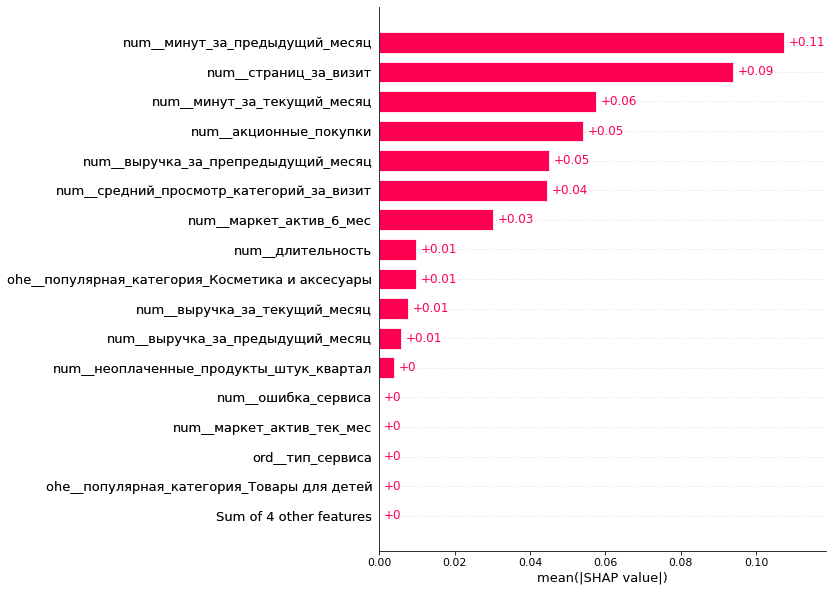

In [75]:
# графики
shap.plots.bar(shap_values, max_display=17)

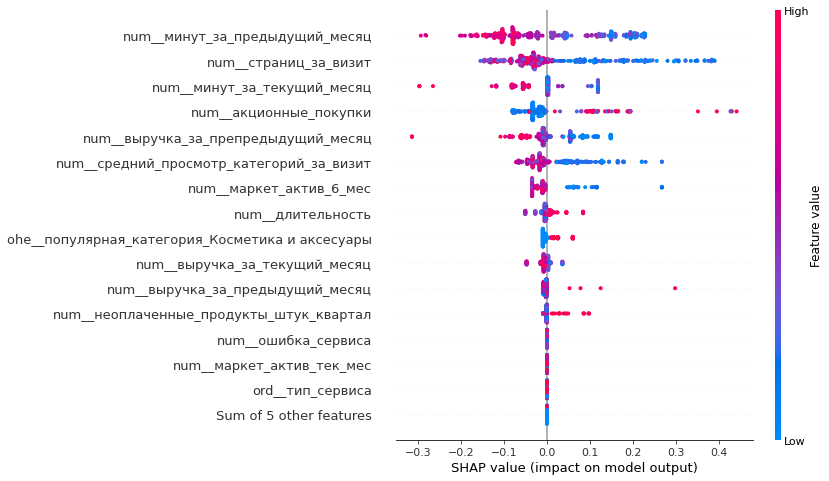

In [76]:
shap.plots.beeswarm(shap_values, max_display=16)

In [77]:
#выведем само дерево для лучшей его интерпретации
model = DecisionTreeClassifier(max_depth=8, min_samples_leaf=10, min_samples_split=70, random_state=RANDOM_STATE)

model.fit(X_train_df, y_train)

DecisionTreeClassifier(max_depth=8, min_samples_leaf=10, min_samples_split=70,
                       random_state=42)

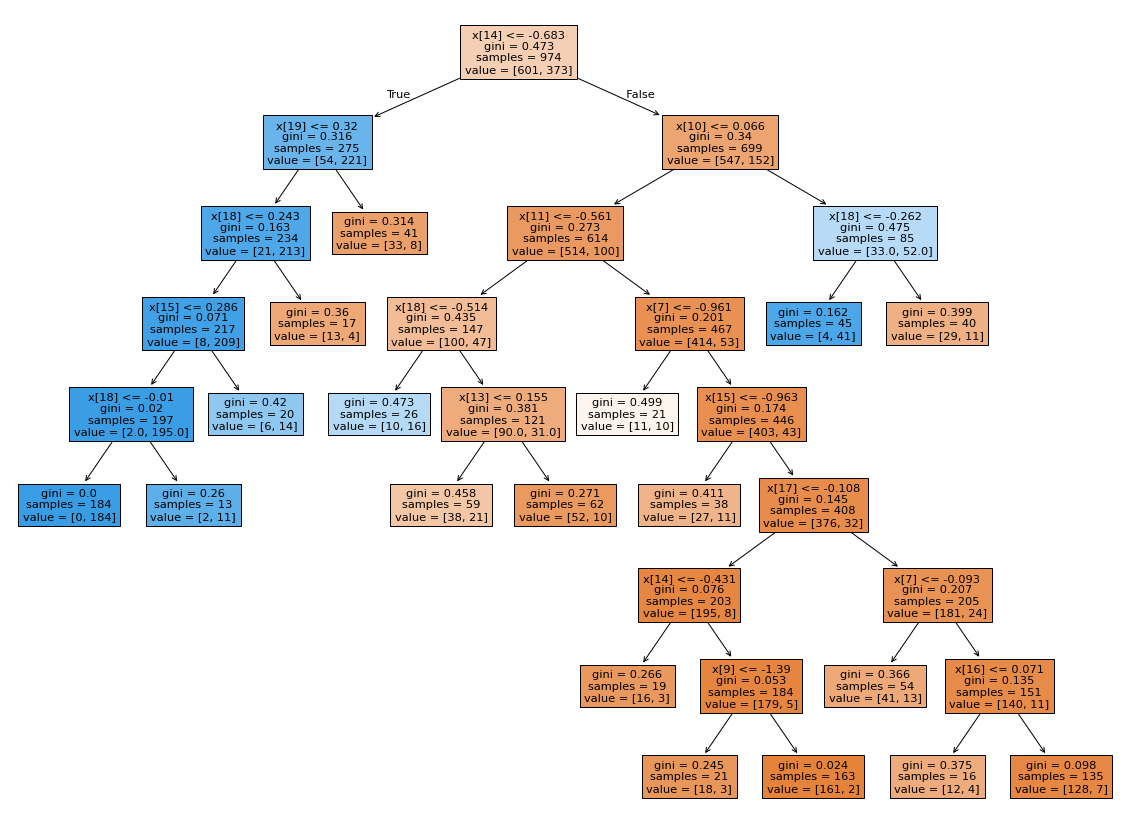

In [78]:
fig = plt.figure(figsize=(20,15)) # Adjust dimensions as needed
plot_tree(decision_tree=model, filled=True)
plt.show()

In [79]:
#выясним чт омодель принимает за класс 0
model.classes_[0]

'Прежний уровень'

**7.2 Сделайте выводы о значимости признаков:**
- какие признаки мало значимы для модели;
- какие признаки сильнее всего влияют на целевой признак;
- как можно использовать эти наблюдения при моделировании и принятии бизнес-решений.

**Вывод по разделу:** 

Согласно графикам SHAP наиболее важными признаками являются мин_за_предыдущий_месяц, страниц_за_визит, акционные покупки. Наименее значимые признаки для модели - популярная категория, длительность, тип_сервиса.

Из графика видно, что высокие значения мин_за_предыдущий_месяц и страниц_за_визит снижают вероятность принадлежности к классу 1 (снизилась), а низкие - наоборот к классу 0 (прежний уровень). 

Данные наблюдения можно использовать при моделировании и принятия бизнес решений. Например, для того, чтобы оставить покупательскую активность на прежнем уровне, необходимо повысить среднее количество страниц, которые просмотрел покупатель за один визит на сайт за последние 3 месяца, а также  значение времени, проведённого на сайте, в минутах за предыдущий месяц. 

## Шаг 8. Сегментация покупателей

**8.1 Выполните сегментацию покупателей. Используйте результаты моделирования и данные о прибыльности покупателей.**

In [80]:
#выведем таблицу df_4
df_4.head()

,id,прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21


In [81]:
#выведем предсказания модели
y_pred_proba = randomized_search.predict_proba(X_test)[:, 1]
predictions_df = pd.DataFrame(y_pred_proba, columns=['вероятность_снижения'], index=X_test.index)

In [82]:
#выведем
predictions_df.head()

,вероятность_снижения
id,
216446,0.27500
215467,1.00000
216301,0.15873
215711,1.00000
215498,1.00000


In [83]:
#объединим таблицы и посмотрим таблицу
congregation_df = pd.merge(df_4, predictions_df, on='id', how='left')
congregation_df = congregation_df.dropna()

In [84]:
congregation_df.head()

,id,прибыль,вероятность_снижения
0,215348,0.98,1.000000
2,215350,3.13,1.000000
4,215352,4.21,1.000000
5,215353,3.95,0.857143
6,215354,3.62,1.000000


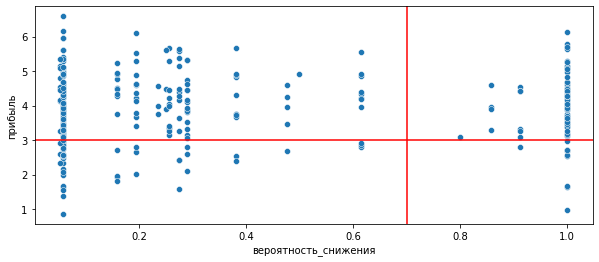

In [85]:
sns.scatterplot(data=congregation_df, x='вероятность_снижения', y='прибыль')
plt.axvline(x=0.7, color='red')
plt.axhline(y=3, color='red')
plt.show()

**8.2 Выберите группу покупателей и предложите, как увеличить её покупательскую активность:** 

Проведите графическое и аналитическое исследование группы покупателей.

In [86]:
#выберем нужный сегмент 
congregation_df_active = congregation_df.query('вероятность_снижения > 0.7 & прибыль > 3')

In [87]:
congregation_df_active.head()

,id,прибыль,вероятность_снижения
2,215350,3.13,1.000000
4,215352,4.21,1.000000
5,215353,3.95,0.857143
6,215354,3.62,1.000000
7,215355,5.26,1.000000


In [88]:
group_buyers = pd.merge(merged_df, congregation_df_active, on='id', how='left')

In [89]:
group_buyers = group_buyers.dropna()

In [90]:
group_buyers.head()

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,выручка_за_препредыдущий_месяц,выручка_за_предыдущий_месяц,выручка_за_текущий_месяц,минут_за_предыдущий_месяц,минут_за_текущий_месяц,прибыль,вероятность_снижения
2,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,4826.0,5457.5,5058.4,8,13,3.13,1.000000
4,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,4594.0,5807.5,5872.5,8,11,4.21,1.000000
5,215353,Снизилась,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,5124.0,4738.5,5388.5,10,10,3.95,0.857143
6,215354,Снизилась,стандарт,да,5.1,3,431,0.23,Косметика и аксесуары,2,3,7,2,4503.0,5685.0,5869.6,11,12,3.62,1.000000
7,215355,Снизилась,стандарт,нет,4.7,4,284,0.17,Товары для детей,5,1,6,4,4749.0,3263.0,3772.6,12,10,5.26,1.000000


In [91]:
group_buyers.describe()

,id,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,выручка_за_препредыдущий_месяц,выручка_за_предыдущий_месяц,выручка_за_текущий_месяц,минут_за_предыдущий_месяц,минут_за_текущий_месяц,прибыль,вероятность_снижения
count,81.000000,81.000000,81.00000,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000
mean,215559.456790,3.662963,4.08642,591.074074,0.473086,2.654321,3.975309,4.012346,3.864198,4569.666667,4946.580247,5314.695062,9.641975,10.148148,4.188148,0.983892
std,190.740206,1.015067,0.71059,236.492430,0.305666,1.184910,2.361013,2.130105,1.902322,571.018848,983.714696,920.548707,2.215337,2.361732,0.727052,0.043015
min,215350.000000,0.900000,3.00000,110.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,3083.700000,5.000000,5.000000,3.080000,0.800000
25%,215421.000000,3.000000,4.00000,434.000000,0.240000,2.000000,2.000000,2.000000,3.000000,4443.000000,4435.000000,4735.000000,8.000000,9.000000,3.620000,1.000000
50%,215546.000000,3.900000,4.00000,589.000000,0.330000,3.000000,4.000000,4.000000,4.000000,4594.000000,5179.500000,5424.200000,10.000000,10.000000,4.180000,1.000000
75%,215649.000000,4.400000,5.00000,773.000000,0.890000,3.000000,6.000000,5.000000,5.000000,4805.000000,5470.500000,5980.800000,12.000000,12.000000,4.590000,1.000000
max,216595.000000,5.600000,5.00000,1065.000000,0.990000,6.000000,10.000000,8.000000,14.000000,5555.000000,6716.500000,7799.400000,14.000000,17.000000,6.120000,1.000000


In [92]:
group_buyers_all = pd.merge(merged_df, congregation_df, on='id', how='left')
group_buyers_all = group_buyers_all.dropna()
group_buyers_all.head()

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,выручка_за_препредыдущий_месяц,выручка_за_предыдущий_месяц,выручка_за_текущий_месяц,минут_за_предыдущий_месяц,минут_за_текущий_месяц,прибыль,вероятность_снижения
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5,0.0,0.0,3293.1,13,14,0.98,1.000000
2,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,4826.0,5457.5,5058.4,8,13,3.13,1.000000
4,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,4594.0,5807.5,5872.5,8,11,4.21,1.000000
5,215353,Снизилась,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,5124.0,4738.5,5388.5,10,10,3.95,0.857143
6,215354,Снизилась,стандарт,да,5.1,3,431,0.23,Косметика и аксесуары,2,3,7,2,4503.0,5685.0,5869.6,11,12,3.62,1.000000


array([[<AxesSubplot:title={'center':'маркет_актив_6_мес'}>,
        <AxesSubplot:title={'center':'маркет_актив_тек_мес'}>,
        <AxesSubplot:title={'center':'длительность'}>,
        <AxesSubplot:title={'center':'акционные_покупки'}>],
       [<AxesSubplot:title={'center':'средний_просмотр_категорий_за_визит'}>,
        <AxesSubplot:title={'center':'неоплаченные_продукты_штук_квартал'}>,
        <AxesSubplot:title={'center':'ошибка_сервиса'}>,
        <AxesSubplot:title={'center':'страниц_за_визит'}>],
       [<AxesSubplot:title={'center':'выручка_за_препредыдущий_месяц'}>,
        <AxesSubplot:title={'center':'выручка_за_предыдущий_месяц'}>,
        <AxesSubplot:title={'center':'выручка_за_текущий_месяц'}>,
        <AxesSubplot:title={'center':'минут_за_предыдущий_месяц'}>],
       [<AxesSubplot:title={'center':'минут_за_текущий_месяц'}>,
        <AxesSubplot:title={'center':'прибыль'}>,
        <AxesSubplot:title={'center':'вероятность_снижения'}>,
        <AxesSubplot:>]], dtype

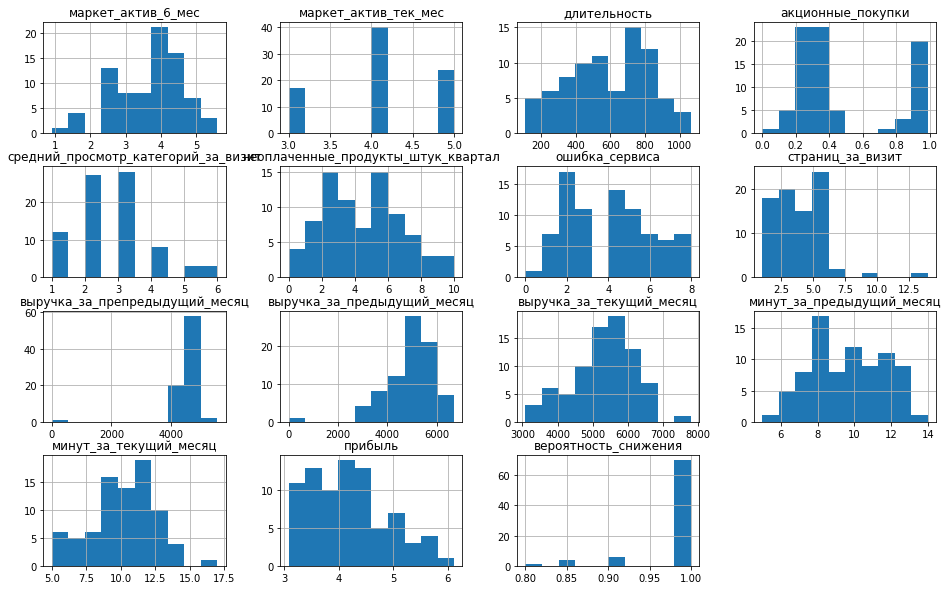

In [99]:
group_buyers.drop('id', axis=1).hist(figsize=(16, 10))

array([[<AxesSubplot:title={'center':'маркет_актив_6_мес'}>,
        <AxesSubplot:title={'center':'маркет_актив_тек_мес'}>,
        <AxesSubplot:title={'center':'длительность'}>,
        <AxesSubplot:title={'center':'акционные_покупки'}>],
       [<AxesSubplot:title={'center':'средний_просмотр_категорий_за_визит'}>,
        <AxesSubplot:title={'center':'неоплаченные_продукты_штук_квартал'}>,
        <AxesSubplot:title={'center':'ошибка_сервиса'}>,
        <AxesSubplot:title={'center':'страниц_за_визит'}>],
       [<AxesSubplot:title={'center':'выручка_за_препредыдущий_месяц'}>,
        <AxesSubplot:title={'center':'выручка_за_предыдущий_месяц'}>,
        <AxesSubplot:title={'center':'выручка_за_текущий_месяц'}>,
        <AxesSubplot:title={'center':'минут_за_предыдущий_месяц'}>],
       [<AxesSubplot:title={'center':'минут_за_текущий_месяц'}>,
        <AxesSubplot:title={'center':'прибыль'}>,
        <AxesSubplot:title={'center':'вероятность_снижения'}>,
        <AxesSubplot:>]], dtype

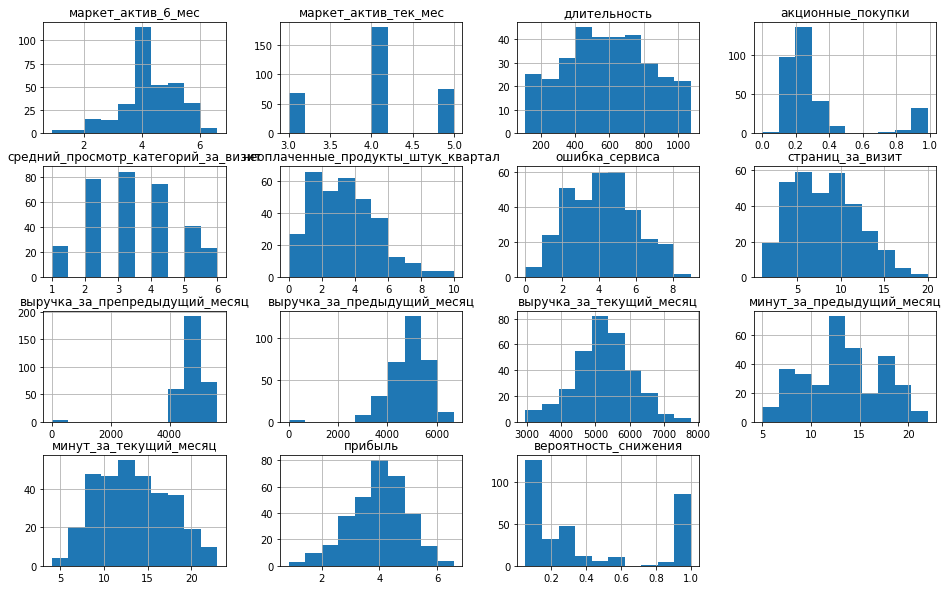

In [98]:
group_buyers_all.drop('id', axis=1).hist(figsize=(16, 10))

Сделайте предложения по работе с сегментом для увеличения покупательской активности.

На них можно попробовать повлиять, например, через таргетированную на эту группу маркетинговую кампанию.

**8.3 Сделайте выводы о сегментах:**
- какой сегмент вы взяли для дополнительного исследования,
- какие предложения вы сделали и почему.

Взяли сегмент с итоговой вероятностью снижения более 0.7, и прибылью больше 3. Предложил провести рекламу.

## Шаг 9. Общий вывод

Сделайте общий вывод:
опишите задачу;
опишите исходные данные и проведённую предобработку;
напишите, что вы сделали для поиска лучшей модели;
укажите лучшую модель;
добавьте выводы и дополнительные предложения для выбранного сегмента покупателей.

**Итоговый вывод:**

Исходные данные 4 - датафрейма. Провели предобработку данных (проверили явные и не явные дубликаты, пропуски). Для поиска наилучшей модели использовали пайплайн совместно с randomizedsearch. Лучшая модель - дерево решений с параметрами (max_depth=7, min_samples_leaf=4, min_samples_split=62). Провели сегментацию покупателей. Выбрали сегмент с итоговой вероятностью снижения более 0.7, и прибылью больше 3. Предложил провести рекламу.